# Advanced Statistical Inference -- Variational Inference for Bayesian Logistic Regression

In this notebook, you will learn how to implement the (stochastic) variational inference algorithm.
The gist below will serve you as a refresh on variational inference.
For additional information, please check the lecture notes.

In the general setting, given a probabilistic model with observations $\{\boldsymbol{X},\boldsymbol{y}\}$, model parameters $\boldsymbol{w}$ and likelihood $p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})$, by introducing an approximate posterior distribution $q_\theta(\boldsymbol{w})$ with parameters $\theta$, the variational lower bound to the log-marginal likelihood is defined as


$$\mathrm{KL}[{q_\theta(\boldsymbol{w})}||{p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y})}] = -\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) +  \mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}] + \log p(\boldsymbol{y}|\boldsymbol{X}) $$


The objective is then to maximize this variational bound (or evidence lower bound) - the ELBO:

$$
      \mathcal{L}(\theta) = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})}_\text{Expected loglikelihood} -  \mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]
$$

The analytic evaluation of the ELBO is generally still untractable due to the presence of the expected loglikelihood under the variational distribution (in the majority of  cases the rightmost KL is tractable).
This is commonly overcome by sampling $N_\mathrm{MC}$ times from $q_\theta$  using the reparameterization trick

$$
    \mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) \approx \dfrac{1}{N_\mathrm{MC}} \sum_{\tilde{\boldsymbol{w}}_i\sim q_\theta} \log p(\boldsymbol{y}|\boldsymbol{X}, \tilde{\boldsymbol{w}}_i)
$$

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from tqdm.notebook import tqdm

dark = True
colab = "google.colab" in str(get_ipython())
preamble = r"""\renewcommand{\familydefault}{\sfdefault}\usepackage{sansmath}
\usepackage{FiraSans}\sansmath\usepackage{amsmath}"""

rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("text", **{"usetex": False, "latex.preamble": preamble})
rc("figure", **{"dpi": 200})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
)

## Library and coding

This lab is heavily built on JAX. You already used JAX during the lab on Gaussian process regression when you took advantage of the automatic differentation engine to optimize the kernel parameters, without manually writing the derivatives by hand.
This time, we will this same auto-diff engine to optimize our variational objective, but we will also take advantage of another key charateristic of JAX: automatic vectorization. This will allow us to efficiently parallelize the computation of the expected likelihood.


Below, you have a short tutorial on how this works.

**Note**: This notebook is computationally more intensive than the previous ones (cells may run for up to 1 minute). If you are using Google Colab, you can speed up the computation by switching to a GPU runtime. Behind the scenes, JAX will automatically take care of the GPU acceleration for you.

Consider the following simple code that computes the convolution of two one-dimensional vectors:

In [2]:
x = jnp.array([0.0, 1.0, 2.0, 3.0, 4.0])
w = jnp.array([2.0, 3.0, 4.0])


def convolve(x, w):
    y = []
    for i in range(1, len(x) - 1):
        y.append(jnp.dot(x[i - 1 : i + 2], w))
    return jnp.array(y)


y = convolve(x, w)

print(f"x = {x}\nw = {w}\ny = {y}")

x = [0. 1. 2. 3. 4.]
w = [2. 3. 4.]
y = [11. 20. 29.]


Suppose we would like to apply this function to a batch of weights `w` to a batch of vectors `x`

In [3]:
X = jnp.stack([x, 2 * x])
W = jnp.stack([w, 2 * w])

print(f"X = \n{X}\n\nW =\n{W}")

X = 
[[0. 1. 2. 3. 4.]
 [0. 2. 4. 6. 8.]]

W =
[[2. 3. 4.]
 [4. 6. 8.]]


The most naive option would be to simply loop over the batch in Python and then stack the results; this produces the correct result, however it is not very efficient.
In order to batch the computation efficiently, you would normally have to rewrite the function manually to ensure it is done in vectorized form.
This is not particularly difficult to implement for this particular example, but does involve changing how the function treats indices, axes, and other parts of the input.
Such re-implementation can become messy to understand and error-prone; fortunately JAX provides another way.
In JAX, the `jax.vmap` transformation is designed to generate such a vectorized implementation of a function automatically:

In [4]:
Y = jax.vmap(convolve)(X, W)
print(f"X = \n{X}\nW =  \n{W}\nY =  \n{Y}")

X = 
[[0. 1. 2. 3. 4.]
 [0. 2. 4. 6. 8.]]
W =  
[[2. 3. 4.]
 [4. 6. 8.]]
Y =  
[[ 11.  20.  29.]
 [ 44.  80. 116.]]


Additional you can control what to vectorize using `in_axes=[...]`. For example, if you would like to convolve to a single set of weights `w` with a batch of vectors `X` you need to choose `in_axes=[0, None]`: this means "vectorize on the axis 0 of the first arg but do *not* vectorize on the second arg

In [5]:
Y = jax.vmap(convolve, in_axes=[0, None])(X, w)
print(f"X = \n{X}\nw = \n{w}\nY =  \n{Y}")

X = 
[[0. 1. 2. 3. 4.]
 [0. 2. 4. 6. 8.]]
w = 
[2. 3. 4.]
Y =  
[[11. 20. 29.]
 [22. 40. 58.]]


Finally, this `vmap` can be also used as decorator, thus keeping the code cleaner

The Pythonic way to improve the code is to use a decorator and a `partial` function to specify the arguments that should be vectorized.
This is a very powerful feature of JAX, and it is used extensively in the code below.
The `partial` function allows you to specify the arguments of `vmap` (in this case the `in_axes` argument) without having to rewrite the function itself.


In [6]:
from functools import partial

@partial(jax.vmap, in_axes=[0, None])
def convolve(x, w):
    y = []
    for i in range(1, len(x) - 1):
        y.append(jnp.dot(x[i - 1 : i + 2], w))
    return jnp.array(y)


Y = convolve(X, w)
print(f"X = \n{X}\nw =\n {w}\nY =  \n{Y}")

X = 
[[0. 1. 2. 3. 4.]
 [0. 2. 4. 6. 8.]]
w =
 [2. 3. 4.]
Y =  
[[11. 20. 29.]
 [22. 40. 58.]]


In just 1 line of code, we have vectorized the function with respet to one of its arguments, without having to change the function itself.

You can build very complex functions using this approach: just start from the basic building blocks and use `vmap` to vectorize them.

### Random number generation in JAX
To fully exploit the automatic vectorization of JAX, we will need to switch from the Numpy's random generation to JAX's.
The main difference is that JAX is explicit on the definition and usage of the random seed.

In [7]:
rng = jax.random.PRNGKey(0)
print(jax.random.uniform(rng))

0.947667


This also means that in order to have "true" random number generation, we need to manually advance the random seed. **The rule of thumb is: never reuse keys (unless you want identical outputs).**
In order to generate different and independent samples, you must `split()` the key *yourself* whenever you want to call a random function:

In [8]:
print("rng", rng, "--> uniform", jax.random.uniform(rng))
rng, new_rng = jax.random.split(rng)
normal_sample = jax.random.uniform(new_rng)
print(r"    \---SPLIT --> new_rng", new_rng, "--> uniform", jax.random.uniform(new_rng))

rng [0 0] --> uniform 0.947667
    \---SPLIT --> new_rng [ 928981903 3453687069] --> uniform 0.0072938204


While all this sounds exceedingly over-complicated, it also allows to very easily vectorize using `jax.vmap` functions that works on random samples. Take a look at the next cell and try to understand what is going on here.

“Apply take_square to each row (key) of multiple_rng, in parallel.”

In [9]:
def take_square(rng):
    x = jax.random.uniform(rng)
    return x**2


multiple_rng = jax.random.split(rng, 10)
print(jax.vmap(take_square)(multiple_rng))

[0.07993058 0.01087648 0.05220539 0.40073746 0.80360603 0.7290857
 0.06019844 0.01839877 0.09836758 0.11087253]


**Exercise**: Test if you understood the code above. Write a function that take a random key and a constant, generates a Gaussian random variable with mean 0 and variance 1, adds the contant, and returns the result.
Then, use `jax.vmap` to generate a batch of 20 random variables, with the same constant added to each of them (hint: you need to vmap on the first argument, not the second one). Try to use the decorator style, as shown above.

In [10]:
## input: random key and a constant
# method:
# - generate gaussian random variable, mean 0 and variance 1.
# - add constant
# - return result

# use jax.vmap to generate batch of 20 random variables
# add the same constant to each of them

# hint: use vmap on first argument, not the second one.

#@<something>(...)
@partial(jax.vmap, in_axes=[0, None])
def test_function(rng, k):
  return jax.random.normal(rng) + k

multiple_rng = jax.random.split(rng, 20)
# Pass k as a positional argument to match in_axes=[0, None]
out = test_function(multiple_rng, 5)

print(out)

[4.42522   3.7425222 4.2561545 5.3399115 6.2615285 6.053156  4.310816
 3.89989   4.51443   4.568288  4.6577816 6.2780547 5.8579965 6.1685214
 4.2157717 3.9415426 3.952939  5.948308  4.6368456 6.763179 ]


# 1. Setup and data

Similarly to the previous lab, you’re going to implement the VI algorithm described in the lecture for binary classification.

In [11]:
def plot_data(X, y, ax):
    mask = y == 1
    config = dict(edgecolor="black", linewidth=1, zorder=10)
    ax.scatter(*X[mask].T, label="Class 1", facecolor="tab:blue", **config)
    ax.scatter(*X[~mask].T, label="Class 0", facecolor="tab:orange", **config)


def get_grid(xlim=(-3, 3), ylim=None, N=100):
    if ylim is None:
        ylim = xlim
    x_grid = np.linspace(*xlim, N)
    y_grid = np.linspace(*ylim, N)
    xx, yy = np.meshgrid(x_grid, y_grid)
    X_plot = np.vstack((xx.flatten(), yy.flatten())).T
    return xx, yy, X_plot

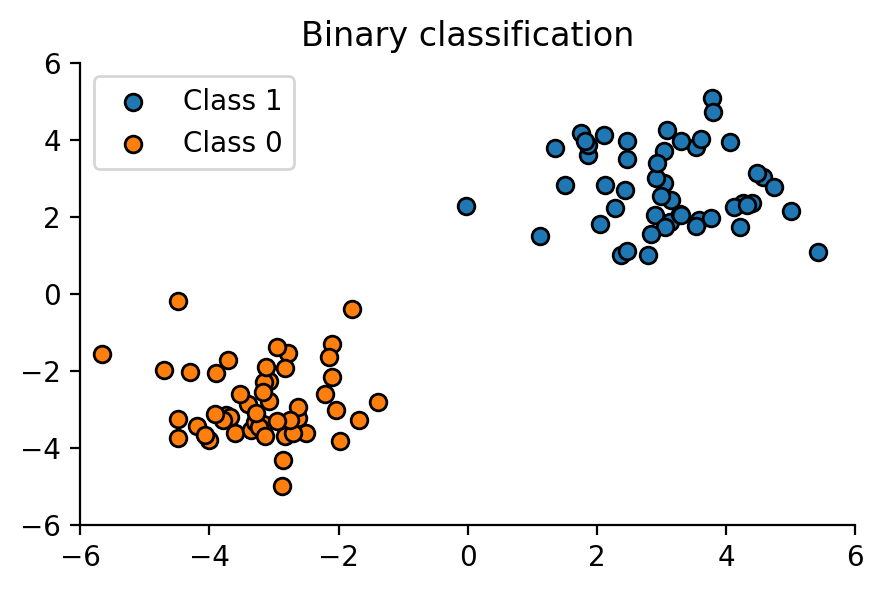

In [12]:
data = np.loadtxt("https://github.com/eurecom-ds/asi-labs/raw/refs/heads/master/lab_week2/binaryclass2.csv", delimiter=",")
X = data[..., :-1]
y = data[..., -1]

fig, ax = plt.subplots(figsize=[5, 3])
plot_data(X, y, ax)
ax.set_title("Binary classification")
ax.legend()
ax.set_xlim(-6, 6), ax.set_ylim(-6, 6)
plt.show()

Let's start by defining some probability distributions that we will need in this notebook.
First, the Bernoulli distribution.

**Exercise:**
Complete the following class to compute the logdensity of the Bernoulli distribution. Since we will be taking gradients of this likelihood, it's possible that during optimization $p$ becomes (down to machine precision) exactly 0 or 1, which makes the evaluation of the logarithm troublesome. To avoide this behavior, simply add a small quantity (like `1e-6`) before computing the log.

In [13]:
def bernoulli_logdensity(y, p):
    epsilon = 1e-6
    p = jnp.clip(p, epsilon, 1 - epsilon)
    # Bernoulli log-likelihood: y * log(p) + (1 - y) * log(1 - p)
    out = y * jnp.log(p) + (1 - y) * jnp.log(1 - p)
    return out

Now let's move to the Gaussian distribution. Note that the parameter $\sigma^2$ is always expected to be positive while it is possible that the optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues.
A commonly-used technique to enforce this condition is to work with a transformed version of parameters using the logarithm transformation.
In particular, define $\psi = \log\sigma^2$.
So remember to take the exponential of $\psi$ if you want to use $\sigma^2$.

The following class implements the Gaussian distribution, with a vector of means and a vector of log-variances.

In [14]:
from functools import partial
from typing import NamedTuple


class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

**Exercise**: Complete the next function to generate *one* sample from a Gaussian distribution using the reparameterization trick. Remember $p(\boldsymbol z) = p(t(\boldsymbol \varepsilon;\boldsymbol \theta))$ where $t(\cdot) = \boldsymbol \mu + \boldsymbol \sigma \odot \boldsymbol \varepsilon$ and $\boldsymbol \varepsilon \sim \mathcal{N}(\boldsymbol 0, \boldsymbol I)$

In [22]:
def sample_gaussian_diagonal(rng, params):
    """
    Sample from a Gaussian distribution with diagonal covariance.

    Args:
        rng: Random number generator key.
        params: A named tuple containing the mean and log variance of the Gaussian.
            mean: Mean of the Gaussian distribution.
            log_var: Log variance of the Gaussian distribution.
    """
    eps = jax.random.normal(rng, shape=params.mean.shape)
    # invert the log-variance to get the standard deviation std
    std = np.exp(params.log_var * 0.5)
    # out = params.mean + params.variance * eps (standard normal noice)
    out = params.mean + std * eps
    return out

**Exercise**: Create a Gaussian with two components with $\mathcal{N}(\boldsymbol 0, \boldsymbol 1)$ and get one sample.

In [23]:
rng = jax.random.PRNGKey(0)
p_params = GaussianDiagonal(jnp.zeros(2), jnp.zeros(2))
print(sample_gaussian_diagonal(rng, p_params))

[1.6226422 2.0252647]


# 2. KL Divergence

The expression of the KL divergence between multivariate Gaussians $q = \mathcal{N}(\boldsymbol{\mu}_q, \boldsymbol\Sigma_q)$ and $p = \mathcal{N}(\boldsymbol{\mu}_p, \boldsymbol\Sigma_p)$ is as follows:

\begin{equation}
\mathrm{KL}[q || p] =
\frac{1}{2} \mathrm{Tr}(\boldsymbol\Sigma_p^{-1} \boldsymbol\Sigma_q)
+ \frac{1}{2} (\boldsymbol\mu_p - \boldsymbol\mu_q)^{\top} \boldsymbol\Sigma_1^{-1} (\boldsymbol\mu_p - \boldsymbol\mu_q)
- \frac{D}{2}
+ \frac{1}{2} \log\left( \frac{\mathrm{det}\boldsymbol\Sigma_p}{\mathrm{det}\boldsymbol\Sigma_q} \right)
\end{equation}


This formula simplifies when the two Gaussians have diagonal covariance, i.e. $q = \mathcal{N}(\boldsymbol{\mu}_q, \boldsymbol{\sigma}^2_q\mathrm{I})$ and $p = \mathcal{N}(\boldsymbol{\mu}_p, \boldsymbol{\sigma}^2_p\mathrm{I})$,

$$
\mathrm{KL}[q || p] =  \frac{1}{2} \sum\left( \log \frac{\sigma^2_p}{\sigma^2_q} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \right)
$$


**Exercise:**
Complete the next function to compute the KL divergence between two multivariate Gaussian distribution with diagonal covariance. *Note:* Since we have parameterized the Gaussian distribution with the logvariance, the formula above can be simplified even further.

In [24]:
def kl_diag_diag(q_params: GaussianDiagonal, p_params: GaussianDiagonal):
    """
    Compute the KL divergence between two Gaussian distributions with diagonal covariance.

    Args:
        q_params: A named tuple containing the mean and log variance of the first Gaussian.
        p_params: A named tuple containing the mean and log variance of the second Gaussian.
    """
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)

    p_std2 = np.exp(p_params.log_var)
    q_std2 = np.exp(q_params.log_var)

    kl = 0.5 * np.sum(np.log((p_std2 / q_std2)) + ((q_std2 + (q_params.mean - p_params.mean) ** 2) / (p_std2 ** 2)) - 1)
    return kl

**Exercise:**
Create two identical Gaussian distributions and compute the KL divergence using the function. What's the result? Is it what you were expecting?

Answer: The KL is the same for the two Gaussians. This was expected, since KL divergence is a measure of the difference between two probability distributions.

In [26]:
p_params = GaussianDiagonal(jnp.zeros(2), jnp.zeros(2))
q_params = GaussianDiagonal(jnp.zeros(2), jnp.zeros(2))

print("KL =", kl_diag_diag(q_params, p_params))

KL = 0.0


# 3. Model

Now we can move to design the model. We will use a simple logistic regression very similarly to what done in the previous MCMC lab.
This very simple model computes $h(\boldsymbol{x}) = h(\boldsymbol{w}^\top\boldsymbol{x})$, where $h(\cdot)$ is the logistic function.

**Exercise:**
Complete the next two functions to compute (i) the logistic function and (ii) the output of the model, given a particular choice of $\boldsymbol w$.

In [28]:
def logistic(z):
    """
    Logistic (sigmoid) function. Defined as h(z) = 1 + exp(-z)^-1
    """
    out = 1 / ( 1 + jnp.exp(-z))
    return out


def model(w, X):
    """
    Logistic regression model.
    Args:
        w: Model parameters.
        X: Input data.
    """
    data = jnp.dot(w.T, X)
    out = logistic(data)
    return out

# 4. Variational objective

The objective is to maximize this variational bound:
$$
      \mathcal{L}(\theta) = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})}_\text{Expected loglikelihood} -\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]
$$

**Exercise:**
Complete the next cell to compute the ELBO.

In [ ]:
def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """
    Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence

    Args:
        sample_fn: Function to sample from the posterior.
        likelihood_fn: Likelihood function.
        kl_divergence_fn: KL divergence function
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """
        Compute the log-likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorized multiple MC sample automatically

        Args:
            rng: Random number generator key.
            q_params: Parameters of the posterior distribution.
            X: Input data.
            y: Labels.
        """
        # @@ COMPLETE @@
        # # Get one sample of w using the sample_fn and the parameters of q
        # w =
        # # Predict the output using the sample before
        # yp =
        # # Compute the likelihood and return it (remember that the data points are independent, so the likelihood is the product of the individual likelihoods, which is the ... of the individual log likelihoods)
        # ll =
        return ll

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """
        Computes the ELBO with multiple samples

        Args:
            q_params: Parameters of the posterior distribution.
            p_params: Parameters of the prior distribution.
            rng: Random number generator key.
            X: Input data.
            y: Labels.
            Nmc: Number of Monte Carlo samples to use for the ELBO estimation.
        """
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # @@ COMPLETE @@
        # # Compute the values of the elbo
        # likelihood_vals =
        # # Compute the expectation (i.e. take the mean)
        # expected_likelihood =
        # # Compute the KL divergence
        # kl =
        # # Compute the ELBO
        # elbo =

        # # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

**Exercise:**
Using the function above, create the function to compute the ELBO.

In [ ]:
elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,
    kl_divergence_fn=kl_diag_diag,
    likelihood_fn=bernoulli_logdensity,
)

**Exercise:**
Try to compute the variational objective (use 10 Monte Carlo samples).

In [ ]:
# @@ COMPLETE @@
# elbo, (likelihood, kl) =

print("ELBO =", elbo)
print("Likelihood =", likelihood)
print("KL =", kl)

## 4.1 Analysis of the MC estimate of the ELBO

Ok, now that everything is done and ready we can start to make some analysis.

First of all, as we said we don't have an analytical formula for the variational objective (our loss). We can only access (unbiased) samples, hence the next question.

**Exercise:**
Try to sample using 100 different random seeds the ELBO with [2, 10, 100, 1000] MC samples and plot their distribution with boxplots.

In [ ]:
elbo_samples = pd.DataFrame()
n_repetition = 100

for Nmc in [2, 10, 100, 1000]:
    elbo_samples[Nmc] = np.stack(
        [
            elbo_fn(q_params, p_params, jax.random.PRNGKey(i), X, y, Nmc=Nmc)[0]
            for i in range(n_repetition)
        ]
    )

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
sns.boxplot(data=elbo_samples, whis=np.inf)
ax.set_title("Samples of the MC estimate of the ELBO")
ax.set_xlabel("Number of MC samples")
ax.set_ylabel("ELBO")
ax.margins(0, 0.05)

plt.show()

We said that, in case of large datasets, this can be computationally challenging, due to the evaluation of the likelihood $N_\mathrm{MC}$ times.
But we know that the ELBO can be approximated even further using mini-batching.
Taking a random subset of data $\mathcal{B}$, the approximation becomes

$$
    \mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) \approx \dfrac{1}{N_\mathrm{MC}} \frac{N}{|\mathcal{B}|}\sum_{\tilde{\boldsymbol{w}}_i\sim q_\theta} \sum_{\boldsymbol{X}_j, \boldsymbol{y}_j\sim\mathcal{B}} \log p(\boldsymbol{y}_j|\boldsymbol{X}_j, \tilde{\boldsymbol{w}}_i)
$$

This introduces even more variance in the estimate of the ELBO but it allows to scale to (virtually) any sized dataset.
You are free to extend this to our ELBO estimator, but for the simple example we are using today, this is not required.

# 5. Optimization

Ok, now we can move to the optimization of the ELBO:
$$
\boldsymbol \theta_{t+1} = \boldsymbol \theta_t + \text{lr}\cdot(\nabla_{\boldsymbol \theta} \mathcal{L})(\boldsymbol \theta_t)
$$
Below you have a simple function to implement this update

In [ ]:
def sgd_update(params, gradients, learning_rate=1e-3):
    """
    Perform a stochastic gradient ascent update on the parameters.
    Args:
        params: Parameters to be updated.
        gradients: Gradients of the parameters.
        learning_rate: Learning rate for the update.
    """
    updated_params = jax.tree.map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params

And here the function to compute the gradient (this function will also be compiled using `jax.jit` for better optimization and faster running times).

In [ ]:
grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

**Exercise:**
Write the training loop to optimize the ELBO (use a learning rate of $10^{-3}$). At every step, store the value of the ELBO, of the expected likelihood and the KL.

In [ ]:
rng = jax.random.PRNGKey(0)
q_params = GaussianDiagonal(jnp.zeros(2), jnp.zeros(2))

elbo_summary = [] # Keep track of the ELBO
lik_summary = [] # Keep track of the likelihood
kl_summary = [] # Keep track of the KL divergence

for i in tqdm(range(10000), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params, p_params, rng2, X, y, 100)
    q_params = sgd_update(q_params, q_params_grad, 1e-3)

    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)

In [ ]:
print("Converged posterior")
print("Mean =", q_params.mean)
print("Var =", np.exp(q_params.log_var))

**Exercise:**
Assess convergence of the optimization by plotting the three metrics.

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[8, 2.5])

ax0.plot(elbo_summary, label="ELBO")
ax1.plot(
    lik_summary,
    color="tab:orange",
    label=r"$E_{q(\mathbf{w})} \log p(\mathbf{y}|\mathbf{X},\mathbf{w})$",
)
ax2.plot(
    kl_summary,
    color="tab:green",
    label=r"$\mathrm{KL}[{q(\mathbf{w})}||{p(\mathbf{w})}]$",
)

ax0.semilogx()
ax1.semilogx()
ax2.semilogx()

ax0.axhline(-2.68, color="xkcd:red", label=r"$\log p(\mathbf{y}|\mathbf{X})$")
ax0.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax1.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax2.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")

ax0.set_xlabel("Iteration")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Iteration")

plt.show()

**Question:**
Analyze the behaviour of these three values and comment the plots. Focus you analysis on the breakdown of the ELBO in its parts.

### Making predictions
Now that we have trained the model, we can use it to make predictions on new data.


\begin{equation}
\mathbb{E}_{q(\boldsymbol{w})}h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) = \int h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) q(\boldsymbol{w}) \mathrm{d}\boldsymbol{w}
\end{equation}


With 1000 samples, compute the probability $P (y_\mathrm{new} = 1 | \boldsymbol{x}_\mathrm{new}, \boldsymbol{X}, \boldsymbol{y})$ when $\boldsymbol{x}_\mathrm{new} = [2,-4]^\top$. Compare the result with the number you got from the previous lab.


In [ ]:
def predict_y(sample_fn, q_params, Xt, rng, Nmc=10):
    """
    Compute the outputs of the model by sampling the posterior, then take the expectation

    Args:
        sample_fn: Function to sample from the posterior.
        q_params: Parameters of the posterior distribution.
        Xt: Input data for prediction.
        rng: Random number generator key.
        Nmc: Number of Monte Carlo samples to use for the prediction.
    """

    @jax.vmap
    def predict_y_single(rng):
        """
        Predict the output for a single sample of the posterior.

        Note: This function is vectorized to allow for multiple samples of the posterior.
        """
        # @@ COMPLETE @@
        # w =
        # yp =
        return yp

    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    # @@ COMPLETE @@
    ## Compute the predictions for all the samples
    # yp_samples =
    ## Compute the mean of the predictions
    # yp =
    return yp


yp = predict_y(sample_gaussian_diagonal, q_params, [2, -4], rng, Nmc=1000)
print(yp)

**Execise:**
Let's now plot the distribution at convergence and the predictions on a grid of points.

In [ ]:
import scipy.stats


def plot_gaussian(params, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    xx, yy, w_plot = get_grid(xlim=(-1.5, 5.5), N=250)
    if isinstance(params, GaussianDiagonal):
        cov = np.exp(params.log_var) * np.eye(2)
    else:
        cov = params.L @ params.L.T
    zz = (
        scipy.stats.multivariate_normal(mean=params.mean, cov=cov)
        .pdf(w_plot)
        .reshape(*xx.shape)
    )

    levels = np.linspace(1e-5, np.max(zz), 10)
    ax.contourf(xx, yy, zz, cmap="cividis", alpha=0.8, levels=levels)
    ax.contour(xx, yy, zz, cmap="cividis", levels=levels)

    ax.set_xlabel(r"$\boldsymbol{w}_0$")
    ax.set_ylabel(r"$\boldsymbol{w}_1$")


def plot_posterior(ax):
    xx, yy, w_plot = get_grid(xlim=(-1.5, 5.5), N=250)
    zz = np.zeros(len(w_plot))
    for i, w in enumerate(w_plot):
        zz[i] = bernoulli_logdensity(y, model(w, X)).sum() -0.5* w.T@w
    zz = np.exp(zz).reshape(*xx.shape)
    levels = np.linspace(1e-5, np.max(zz), 10)
    ax.contourf(xx, yy, zz, cmap="cividis", alpha=0.8, levels=levels)
    ax.contour(xx, yy, zz, cmap="cividis", levels=levels)
    ax.set_xlabel(r"$\boldsymbol{w}_0$")
    ax.set_ylabel(r"$\boldsymbol{w}_1$")

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[12, 4])

plot_gaussian(p_params, ax=ax0)
plot_posterior(ax=ax1)
plot_gaussian(q_params, ax=ax2)

ax0.set_title("Prior")
ax1.set_title("True posterior")
ax2.set_title("Variational approx.")

plt.show()

In [ ]:
def plot_decision_boundary(xx, yy, P, ax):
    P = P.reshape(*xx.shape)
    levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    cs = ax.contour(xx, yy, P, levels, colors="k", linewidths=1.8, zorder=100)
    ax.clabel(cs, inline=1, fontsize=10)
    cs = ax.contourf(xx, yy, P, levels, cmap="Purples_r", alpha=0.5)


xx, yy, Xt = get_grid((-7, 7), N=50)
ps = predict_y(sample_gaussian_diagonal, q_params, Xt, rng, Nmc=1000)

fig, ax = plt.subplots(figsize=[5, 4])
plot_decision_boundary(xx, yy, ps, ax=ax)
plot_data(X, y, ax=ax)

ax.set_xlabel(r"$\boldsymbol{x}_0$")
ax.set_ylabel(r"$\boldsymbol{x}_1$")
ax.set_title("Predictive density")
plt.show()

**Exercise:**
At convergence, sample 1000 times the ELBO like we did before, and plot it with a boxplot.

In [ ]:
converged_elbos = pd.DataFrame()
n_repetition = 1000
converged_elbos["Diagonal posterior"] = np.stack(
    [
        elbo_fn(q_params, p_params, jax.random.PRNGKey(i), X, y, Nmc=1000)[0]
        for i in range(n_repetition)
    ]
)

In [ ]:
fig, ax = plt.subplots(figsize=[4, 3])
sns.boxplot(
    data=converged_elbos,
    whis=np.inf,
)
ax.axhline(-2.68, color="xkcd:red", label=r"$p(\boldsymbol{y}|\boldsymbol{X})$")
ax.set_title("ELBO at convergence", y=1.02)
ax.legend()
plt.show()

# 6. Alternatives to Mean Field Variational Inference

As we saw from one of the previous question, the approximation that we used is very rough: it recoves some properties of the true posterior but fails to capture the strong correlation that exists in the parameter space.
What we need to do it to increase the complexity and the expressiveness of the variational posterior.
The first step that we can do is to introduce a non-diagonal covariance $\boldsymbol{w} \sim \mathcal{N}(\mu, \Sigma)$, where the covariance $\Sigma=LL^\top$ ($L$ is a lower triangular matrix).

Sampling from such distribution is possible again using the reparameterization trick,

\begin{equation}
\tilde{\boldsymbol{w}} = \mu + \mathrm{Tril}(L)\boldsymbol{\varepsilon} \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(0, \mathrm{I})
\end{equation}

where $\mathrm{Tril}(\cdot)$ returns the lower triangular part of the matrix (the other elements are set to 0).

**Exercise:**
Complete the next functions to model a full covariance Gaussian distribution.

In [ ]:
class GaussianFullCov(NamedTuple):
    mean: jnp.array
    L: jnp.array


def sample_gaussian_fullcov(key, params: GaussianFullCov):
    """
    Sample from a Gaussian distribution with full covariance.

    Args:
        key: Random number generator key.
        params: A named tuple containing the mean and Cholesky factor of the Gaussian.
    """
    #@@ COMPLETE @@
    # eps =
    # out =
    return out

**Exercise:** Try to sample from the distribution and print the result.

In [ ]:
q_params = GaussianFullCov(jnp.zeros(2), jnp.eye(2))

print(sample_gaussian_fullcov(jax.random.PRNGKey(1), q_params))

Now we need to compute the KL divergence between $q$ Gaussian with full covariance and $p$ Gaussian with diagonal covariance.
Remember that the expression of the KL divergence between multivariate Gaussians $q = \mathcal{N}(\boldsymbol{\mu}_q, \Sigma_q)$ and $p = \mathcal{N}(\boldsymbol{\mu}_p, \Sigma_p)$ is as follows:

\begin{equation}
\mathrm{KL}[q || p] =
\frac{1}{2} \mathrm{Tr}(\Sigma_p^{-1} \Sigma_q)
+ \frac{1}{2} (\mu_p - \mu_q)^{\top} \Sigma_p^{-1} (\mu_p - \mu_q)
- \frac{D}{2}
+ \frac{1}{2} \log\left( \frac{\mathrm{det}\Sigma_p}{\mathrm{det}\Sigma_q} \right)
\end{equation}

**Question:**
Given that $q = \mathcal{N}(\boldsymbol{\mu}_q, LL^\top)$ and $p = \mathcal{N}(\boldsymbol{\mu}_p, \sigma^2_p\mathrm{I})$, write the simplified KL divergence.

*Hints:*

- $\mathrm{Tr}(\boldsymbol L \boldsymbol L^\top) = \sum_i\mathrm{diag}(\boldsymbol L)_i^2$

- $\log\mathrm{det}(\boldsymbol L\boldsymbol L^\top) = \sum_i\log\mathrm{diag}(\boldsymbol L)_i^2$


Below, you'll find the KL implemented.

In [ ]:
def kl_full_diag(q_params: GaussianFullCov, p_params: GaussianDiagonal):
    """
    Compute the KL divergence between a Gaussian distribution with full covariance
    and a Gaussian distribution with diagonal covariance.
    Args:
        q_params: A named tuple containing the mean and Cholesky factor of the first Gaussian.
        p_params: A named tuple containing the mean and log variance of the second Gaussian.
    """
    #@@ COMPLETE @@
    # kl =
    return kl

In [ ]:
print(kl_full_diag(q_params, p_params))

**Exercise:**
Create the a new elbo to use Gaussian with full covariance. Because we wrote the code for computing the ELBO to be as modular as possible, you can simply change the KL divergence function and the sampling function and everything else will work.

In [ ]:
# @@ COMPLETE @@
elbo_fn = create_elbo_fn(
)

**Exercise:**
Train this new model exactly the same as before

In [ ]:
grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

In [ ]:
rng = jax.random.PRNGKey(0)
q_params = GaussianFullCov(jnp.zeros(2), jnp.eye(2))

elbo_summary = []
lik_summary = []
kl_summary = []

for i in tqdm(range(10000), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    q_params_grad, (likelihood, kl) = grad_elbo_fn(
        q_params, p_params, rng2, X, y, 100
    )
    q_params = sgd_update(q_params, q_params_grad, 1e-3)

    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)

**Exercise:**
Plot the train curves

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[8, 2.5])

ax0.plot(elbo_summary, label="ELBO")
ax1.plot(
    lik_summary,
    color="tab:orange",
    label=r"$E_{q(\boldsymbol{w})} \log p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})$",
)
ax2.plot(
    kl_summary,
    color="tab:green",
    label=r"$\mathrm{KL}[{q(\boldsymbol{w})}||{p(\boldsymbol{w})}]$",
)

ax0.semilogx()
ax1.semilogx()
ax2.semilogx()

ax0.axhline(-2.68, color="xkcd:red", label=r"$\log p(\boldsymbol{y}|\boldsymbol{X})$")
ax0.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax1.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax2.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")

ax0.set_xlabel("Iteration")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Iteration")

plt.show()

**Exercise:**
Plot the densities.

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[12, 4])

plot_gaussian(p_params, ax=ax0)
plot_posterior(ax=ax1)
plot_gaussian(q_params, ax=ax2)

ax0.set_title("Prior")
ax1.set_title("True posterior")
ax2.set_title("Variational approx.")

plt.show()

**Exercise:**
Plot the predictions.

In [ ]:
xx, yy, Xt = get_grid((-7, 7), N=50)
ps = predict_y(sample_gaussian_fullcov, q_params, Xt, rng, Nmc=1000)

fig, ax = plt.subplots(figsize=[5, 4])
plot_decision_boundary(xx, yy, ps, ax=ax)
plot_data(X, y, ax=ax)

ax.set_xlabel(r"$\boldsymbol{x}_0$")
ax.set_ylabel(r"$\boldsymbol{x}_1$")
ax.set_title("Predictive density")
plt.show()

**Exercise:**
Plot the ELBO at convergence.

In [ ]:
converged_elbos["Full cov. posterior"] = np.stack(
    [
        elbo_fn(q_params, p_params, jax.random.PRNGKey(i), X, y, Nmc=1000)[0]
        for i in range(n_repetition)
    ]
)
fig, ax = plt.subplots(figsize=[4, 3])
sns.boxplot(data=converged_elbos, whis=np.inf)
ax.axhline(-2.68, color="xkcd:red", label=r"$p(\boldsymbol{y}|\boldsymbol{X})$")
ax.set_title("ELBO at convergence", y=1.02)
ax.legend()
plt.show()

**Question:**
Do you observe something interesting?
Remember what the ELBO represents. It is the lower bound of the marginal distribution $p(\boldsymbol{y}|\boldsymbol{X})$. Check the first lab on Bayesian linear regression if you don't remember what the marginal distribution measures. Based solely on this value, which model would you choose? Why?    